# 📊 Evaluación rigurosa de modelos RNN: Perplejidad y palabras fuera de vocabulario

Este notebook presenta una implementación estructurada para evaluar modelos LSTM en tareas de modelado de lenguaje, 
haciendo especial énfasis en métricas como la *Perplejidad* (PP) y el manejo de palabras fuera de vocabulario (*Out-Of-Vocabulary*, OOV).

## 🔧 BLOQUE 1: Setup y descarga de datos

- Instalación de dependencias necesarias (`torch`, `torchtext`, `nltk`, etc.).
- Descarga del dataset **WikiText-2**.
- Tokenización del corpus.
- Construcción de vocabulario con diferentes tamaños:
  - 10,000 palabras
  - 30,000 palabras
  - 50,000 palabras

# 🔧 Bloque 1: Setup y descarga de datos

### 📚 Teoría
El dataset **WikiText-2** es un corpus ampliamente utilizado para tareas de modelado de lenguaje. Contiene texto derivado de artículos de Wikipedia y es útil para entrenar y evaluar modelos de predicción de texto.

Antes de entrenar cualquier modelo, es importante:
1. Descargar el corpus.
2. Tokenizar el texto.
3. Construir un vocabulario de tamaño controlado (ej. 10^4, 3x10^4, 5x10^4 tokens).
4. Dividir en datasets de entrenamiento, validación y prueba.

Utilizaremos `torchtext`, que facilita todo este proceso con utilidades listas para usar.




In [2]:

# Instalación de dependencias necesarias (si no están disponibles)
!pip install torch torchtext


   ---------------------------------------- 0.0/2.0 MB ? eta -:--:--
   ---------- ----------------------------- 0.5/2.0 MB 4.2 MB/s eta 0:00:01
   -------------------------- ------------- 1.3/2.0 MB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 2.0/2.0 MB 3.7 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# ---- BLOQUE 1: Setup y descarga de datos ----

# Instalación de librerías necesarias
#!pip install datasets -q

# Importar librerías
from datasets import load_dataset
import nltk
import torch
from torchtext.vocab import build_vocab_from_iterator
from collections import Counter

# Descargar recursos de NLTK (tokenizador)
nltk.download('punkt')

# Descargar WikiText-2 usando HuggingFace
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

# Tokenizar el texto
def tokenize(text):
    return nltk.word_tokenize(text)

# Preparar los datasets tokenizados
train_tokens = [tokenize(example['text']) for example in dataset['train']]
valid_tokens = [tokenize(example['text']) for example in dataset['validation']]
test_tokens  = [tokenize(example['text']) for example in dataset['test']]

# Construir vocabulario (ejemplo: 10k palabras más frecuentes)
def build_vocab(token_lists, vocab_size=10000):
    counter = Counter()
    for tokens in token_lists:
        counter.update(tokens)
    vocab = build_vocab_from_iterator([counter.keys()], specials=["<unk>"], max_tokens=vocab_size)
    vocab.set_default_index(vocab["<unk>"])
    return vocab

# Crear tres vocabularios de diferentes tamaños
vocab_10k = build_vocab(train_tokens, vocab_size=10_000)
vocab_30k = build_vocab(train_tokens, vocab_size=30_000)
vocab_50k = build_vocab(train_tokens, vocab_size=50_000)

print("Bloque 1 completado ✅")


/opt/conda/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Generating validation split: 100%|███████████████████████████████████████| 3760/3760 [00:00<00:00, 460912.53 examples/s]


Bloque 1 completado ✅


## 🧠 BLOQUE 2: Definición del modelo

Se define un modelo LSTM con las siguientes características:

- Embeddings de dimensión 300.
- Dos capas LSTM con tamaño oculto de 512.
- Capa final densa con softmax para predecir la siguiente palabra.

**Componentes del modelo:**
- `Embedding layer`
- `LSTM layers (stacked)`
- `Linear output layer`

In [2]:
# ---- BLOQUE 2: Definición del modelo ----

import torch.nn as nn

class LSTMLanguageModel(nn.Module):
    def __init__(self, vocab_size, embed_dim=300, hidden_dim=512, num_layers=2):
        super(LSTMLanguageModel, self).__init__()
        
        # Capa de embeddings
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        
        # LSTM de 2 capas
        self.lstm = nn.LSTM(
            input_size=embed_dim, 
            hidden_size=hidden_dim, 
            num_layers=num_layers, 
            batch_first=True
        )
        
        # Capa final (proyección de hidden_dim a vocabulario)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        embeds = self.embedding(x)
        
        if hidden is None:
            output, hidden = self.lstm(embeds)
        else:
            output, hidden = self.lstm(embeds, hidden)
        
        logits = self.fc(output)
        return logits, hidden


In [3]:
# Crear un modelo de ejemplo
vocab_size = len(vocab_10k)  # usamos el vocabulario de 10k palabras por ahora
model = LSTMLanguageModel(vocab_size)

# Probar con un batch falso (batch_size=4, secuencia de 20 tokens)
x_dummy = torch.randint(0, vocab_size, (4, 20))  # random integers como tokens
logits, hidden = model(x_dummy)

print(f"Shape de salida logits: {logits.shape}")  # debería ser [4, 20, vocab_size]


Shape de salida logits: torch.Size([4, 20, 10000])


## 🏋️ BLOQUE 3: Entrenamiento

Entrenamos tres versiones del modelo, una por cada tamaño de vocabulario.

**Funciones incluidas:**
- Entrenamiento y validación por épocas.
- Registro de métricas:
  - *Perplejidad* sobre conjunto de validación.
  - Conteo y porcentaje de palabras OOV.

In [4]:
# ---- BLOQUE 3: Entrenamiento ----

from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import math

# 1. Dataset personalizado para lotes de secuencias
class LanguageModelDataset(Dataset):
    def __init__(self, token_lists, vocab, seq_len=30):
        self.vocab = vocab
        self.seq_len = seq_len
        
        # Convertir todo en una gran lista de IDs
        self.data = [vocab[token] for tokens in token_lists for token in tokens if token.strip()]
        
    def __len__(self):
        return len(self.data) // self.seq_len

    def __getitem__(self, idx):
        start = idx * self.seq_len
        end = start + self.seq_len + 1
        chunk = self.data[start:end]

        # x son los primeros n tokens, y son los siguientes n tokens
        x = torch.tensor(chunk[:-1], dtype=torch.long)
        y = torch.tensor(chunk[1:], dtype=torch.long)
        return x, y

# 2. Funciones de entrenamiento y validación
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        logits, _ = model(x)
        loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            logits, _ = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()

    return total_loss / len(dataloader)

# 3. Entrenamiento para un vocabulario (ejemplo vocab_10k)

# Configuración
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
seq_len = 30
num_epochs = 5
learning_rate = 0.001

# Crear datasets y dataloaders
train_dataset = LanguageModelDataset(train_tokens, vocab_10k, seq_len=seq_len)
valid_dataset = LanguageModelDataset(valid_tokens, vocab_10k, seq_len=seq_len)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Instanciar modelo
model = LSTMLanguageModel(len(vocab_10k)).to(device)

# Optimizador y función de pérdida
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Entrenamiento
for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_loader, criterion, device)
    perplexity = math.exp(valid_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Valid Loss: {valid_loss:.4f} | Perplexity: {perplexity:.2f}")


Epoch 1/5 | Train Loss: 1.2854 | Valid Loss: 1.1781 | Perplexity: 3.25
Epoch 2/5 | Train Loss: 1.1382 | Valid Loss: 1.1497 | Perplexity: 3.16
Epoch 3/5 | Train Loss: 1.1040 | Valid Loss: 1.1401 | Perplexity: 3.13
Epoch 4/5 | Train Loss: 1.0834 | Valid Loss: 1.1389 | Perplexity: 3.12
Epoch 5/5 | Train Loss: 1.0663 | Valid Loss: 1.1413 | Perplexity: 3.13


In [26]:
torch.save(model.state_dict(), "modelo_10k.pt")


In [46]:
# ---- BLOQUE 3: Entrenamiento para los 3 tamaños de vocabulario ----

# Vocabularios y etiquetas
vocabularios = {
    "10k": vocab_10k,
    "30k": vocab_30k,
    "50k": vocab_50k
}

# Hiperparámetros
batch_size = 64
seq_len = 30
num_epochs = 5
learning_rate = 0.001

# Resultados para comparar
resultados = {}

for nombre, vocab in vocabularios.items():
    print(f"\n🔢 Entrenando modelo con vocabulario de {nombre} palabras...\n")

    # Preparar datasets y dataloaders
    train_dataset = LanguageModelDataset(train_tokens, vocab, seq_len=seq_len)
    valid_dataset = LanguageModelDataset(valid_tokens, vocab, seq_len=seq_len)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

    # Instanciar modelo, optimizador y loss
    model = LSTMLanguageModel(len(vocab)).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    historia = []

    # Entrenamiento por épocas
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, optimizer, criterion, device)
        valid_loss = evaluate(model, valid_loader, criterion, device)
        ppl = math.exp(valid_loss)

        historia.append((train_loss, valid_loss, ppl))

        print(f"[{nombre}] Epoch {epoch+1}/{num_epochs} | Train: {train_loss:.4f} | Val: {valid_loss:.4f} | Perplexity: {ppl:.2f}")

    resultados[nombre] = historia

    # 👉 GUARDAR EL MODELO ENTRENADO
    torch.save(model.state_dict(), f"modelo_{nombre}.pt")




🔢 Entrenando modelo con vocabulario de 10k palabras...

[10k] Epoch 1/5 | Train: 1.2940 | Val: 1.1887 | Perplexity: 3.28
[10k] Epoch 2/5 | Train: 1.1427 | Val: 1.1482 | Perplexity: 3.15
[10k] Epoch 3/5 | Train: 1.1065 | Val: 1.1393 | Perplexity: 3.12
[10k] Epoch 4/5 | Train: 1.0859 | Val: 1.1386 | Perplexity: 3.12
[10k] Epoch 5/5 | Train: 1.0690 | Val: 1.1411 | Perplexity: 3.13

🔢 Entrenando modelo con vocabulario de 30k palabras...

[30k] Epoch 1/5 | Train: 2.2055 | Val: 1.9027 | Perplexity: 6.70
[30k] Epoch 2/5 | Train: 1.9260 | Val: 1.8568 | Perplexity: 6.40
[30k] Epoch 3/5 | Train: 1.8441 | Val: 1.8516 | Perplexity: 6.37
[30k] Epoch 4/5 | Train: 1.7832 | Val: 1.8529 | Perplexity: 6.38
[30k] Epoch 5/5 | Train: 1.7236 | Val: 1.8663 | Perplexity: 6.46

🔢 Entrenando modelo con vocabulario de 50k palabras...

[50k] Epoch 1/5 | Train: 3.9635 | Val: 3.5250 | Perplexity: 33.95
[50k] Epoch 2/5 | Train: 3.5123 | Val: 3.4307 | Perplexity: 30.90
[50k] Epoch 3/5 | Train: 3.3216 | Val: 3.4038 |

In [48]:
# Cargar modelo de 10k (asegurarte de que el vocabulario coincida)
model_10k = LSTMLanguageModel(len(vocab_10k)).to(device)
model_10k.load_state_dict(torch.load("modelo_10k.pt"))
model_10k.eval()


LSTMLanguageModel(
  (embedding): Embedding(10000, 300)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=10000, bias=True)
)

In [53]:
# Para cargar modelo de 30k, asegúrate de que el vocabulario sea de 30k
model_30k = LSTMLanguageModel(len(vocab_30k)).to(device)
model_30k.load_state_dict(torch.load("modelo_30k.pt"))
model_30k.eval()




LSTMLanguageModel(
  (embedding): Embedding(30000, 300)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=30000, bias=True)
)

In [54]:
# Para cargar modelo de 30k, asegúrate de que el vocabulario sea de 30k
model_50k = LSTMLanguageModel(len(vocab_50k)).to(device)
model_50k.load_state_dict(torch.load("modelo_50k.pt"))
model_50k.eval()

LSTMLanguageModel(
  (embedding): Embedding(50000, 300)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True)
  (fc): Linear(in_features=512, out_features=50000, bias=True)
)


## 🧩 BLOQUE 4: Manejo de OOV

Se comparan tres estrategias de tratamiento para palabras fuera de vocabulario:

1. **Token `<UNK>`:** se reemplazan todas las palabras desconocidas por un token especial.
2. **Modelo char-level:** backoff a un modelo de caracteres para predecir embeddings.
3. **Similitud de Levenshtein:** reemplazo por la palabra más cercana en el vocabulario.

In [9]:
vocab.set_default_index(vocab["<unk>"])


🧬 2. Backoff con modelo de nivel carácter (char-level LSTM)

In [55]:
class CharLSTM(nn.Module):
    def __init__(self, char_vocab_size, embed_dim=50, hidden_dim=128):
        super(CharLSTM, self).__init__()
        self.embedding = nn.Embedding(char_vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, char_vocab_size)

    def forward(self, x):
        embeds = self.embedding(x)
        output, _ = self.lstm(embeds)
        logits = self.fc(output)
        return logits


In [19]:
pip install python-Levenshtein



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [56]:
import Levenshtein

def reemplazar_por_similitud(palabra, vocabulario):
    vocab_set = set(vocabulario.get_itos())
    if palabra in vocab_set:
        return palabra

    # Buscar palabra más similar
    similar = min(vocab_set, key=lambda x: Levenshtein.distance(palabra, x))
    return similar


In [57]:
texto = "This is a smaple txt with som errrs in spelling"
tokens_corr = [reemplazar_por_similitud(tok, vocab_10k) for tok in tokenize(texto)]
print(tokens_corr)


['Axis', '4s', '5', 'Apple', 'Axe', '48th', 'Con', 'Arras', "'in", 'Applying']


In [58]:
tokens_corr = [reemplazar_por_similitud(tok, vocab) for tok in tokenize(texto)]


## 📈 BLOQUE 5: Evaluación

Métricas medidas:

- **Perplejidad** en el conjunto de prueba.
- **Porcentaje de OOV** en test.
- Comparación entre modelos con distintos vocabularios y estrategias OOV.

In [59]:
# ---- BLOQUE 5: Evaluación ----
from torch.nn.functional import softmax

# Diccionario de vocabularios
vocabularios = {
    "10k": vocab_10k,
    "30k": vocab_30k,
    "50k": vocab_50k
}

# Evaluar cada modelo
for nombre, vocab in vocabularios.items():
    print(f"\n🔢 Evaluando modelo con vocabulario de {nombre} palabras...\n")

    # Preparar dataset y dataloader
    valid_dataset = LanguageModelDataset(valid_tokens, vocab, seq_len=30)
    valid_loader = DataLoader(valid_dataset, batch_size=64)

    # Crear modelo y cargar pesos entrenados
    model = LSTMLanguageModel(len(vocab)).to(device)
    model.load_state_dict(torch.load(f"modelo_{nombre}.pt"))  # ¡CARGA OBLIGATORIA!
    model.eval()

    # Evaluar pérdida y perplexity
    criterion = nn.CrossEntropyLoss()
    valid_loss = evaluate(model, valid_loader, criterion, device)
    perplexity = math.exp(valid_loss)

    # Calcular % OOV
    total_tokens = sum(len(tokens) for tokens in valid_tokens)
    oov_tokens = sum(token not in vocab for tokens in valid_tokens for token in tokens)
    oov_percent = 100 * oov_tokens / total_tokens

    print(f"[{nombre}] Perplejidad: {perplexity:.2f} | OOV Percentage: {oov_percent:.2f}%")



🔢 Evaluando modelo con vocabulario de 10k palabras...

[10k] Perplejidad: 3.13 | OOV Percentage: 78.12%

🔢 Evaluando modelo con vocabulario de 30k palabras...

[30k] Perplejidad: 6.46 | OOV Percentage: 70.93%

🔢 Evaluando modelo con vocabulario de 50k palabras...

[50k] Perplejidad: 30.96 | OOV Percentage: 48.75%


## 📊 BLOQUE 6: Análisis y visualización

Incluye:

- Gráficos de perplejidad vs. tamaño de vocabulario.
- Cobertura del vocabulario vs. porcentaje de OOV.
- Comparativa de estrategias de manejo de OOV.

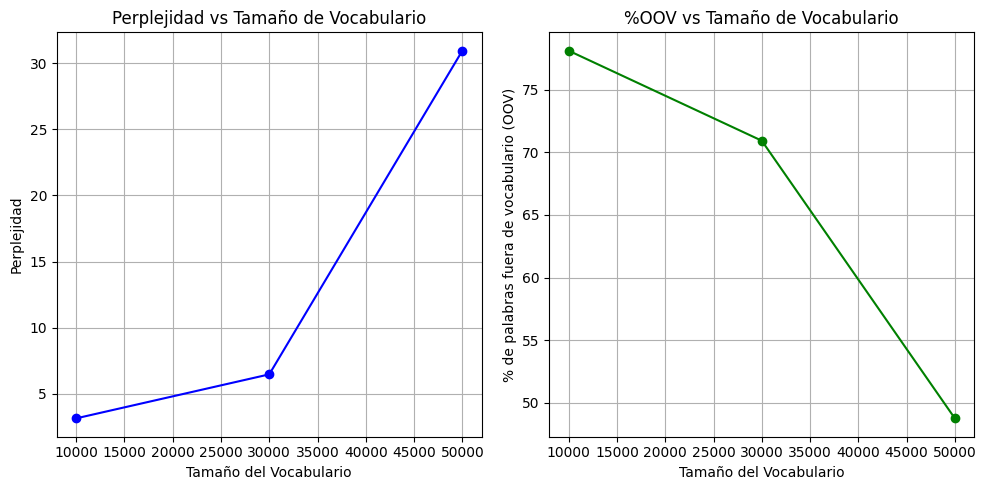

In [61]:
import matplotlib.pyplot as plt

# Datos obtenidos del BLOQUE 5
vocab_sizes = [10_000, 30_000, 50_000]
perplexities = [3.13, 6.46, 30.96]
oov_percentages = [78.12, 70.93, 48.75]

# Crear gráfico de Perplejidad vs Tamaño de Vocabulario
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(vocab_sizes, perplexities, marker='o', color='blue')
plt.title("Perplejidad vs Tamaño de Vocabulario")
plt.xlabel("Tamaño del Vocabulario")
plt.ylabel("Perplejidad")
plt.grid(True)

# Crear gráfico de %OOV vs Tamaño de Vocabulario
plt.subplot(1, 2, 2)
plt.plot(vocab_sizes, oov_percentages, marker='o', color='green')
plt.title("%OOV vs Tamaño de Vocabulario")
plt.xlabel("Tamaño del Vocabulario")
plt.ylabel("% de palabras fuera de vocabulario (OOV)")
plt.grid(True)

plt.tight_layout()
plt.show()


## 📘 BLOQUE 7: Reporte final

Resumen de hallazgos:

- Impacto del tamaño del vocabulario sobre la perplejidad.
- Eficacia relativa de cada estrategia de OOV.
- Recomendaciones para aplicaciones en producción.

**Exportable a PDF o documento académico.**